# Synthetic Data Generation

In this python script, I'll use the actual tiff files for florida to make synthetic data for wetland development.

0. Select the top 10 tiff files with most wetland development (show them on plot)
1. Mark their number and show the their Capital_1996 and DEM respectively
2. Plot DEM and Capital with WetLand Development to find the linear relationship
3. Generate wetland development as those two variables and random noise (tiff file)
4. Generate treatment effect as some function of DEM and Capital 
5. Generate potential outcome

*Date: June 2nd, 2025*


## Preliminary 

In [1]:
# Libraries
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import rasterio as rio
from PIL import Image
import pathlib
import pandas as pd

# Helper functions
DATA_DIR = pathlib.Path('/Users/sayedmorteza/Library/CloudStorage/Box-Box/Hetwet_Data')         

# folders
folders = {
    'wet' : DATA_DIR/'WETLAND_DEV_1996_2016',
    'dem' : DATA_DIR/'DEM',
    'cap' : DATA_DIR/'CAPITAL_1996'
}

## Step 1: Selecting the most development scenes


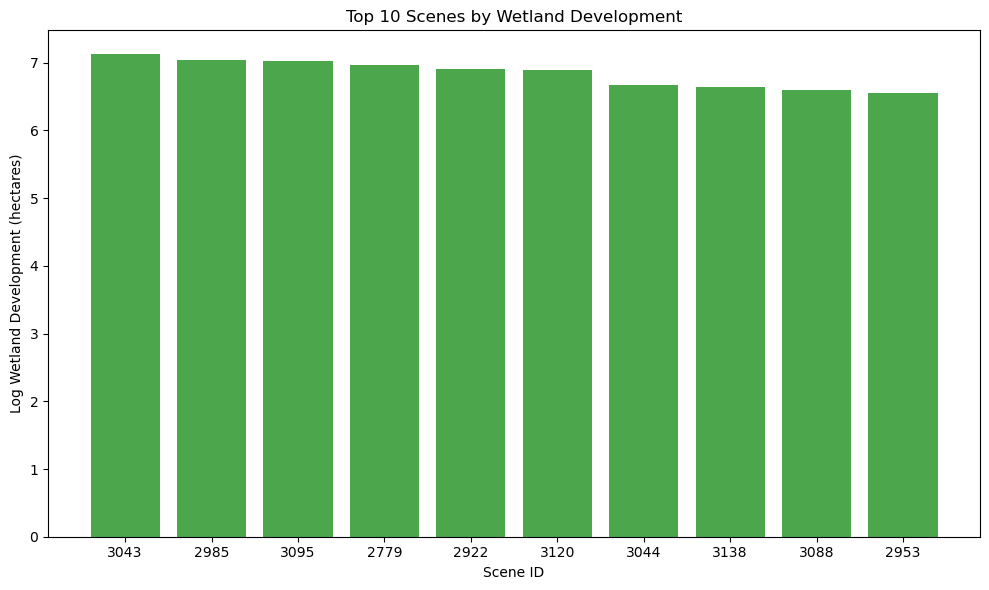

In [2]:
# reading tabular data
cols = ['scene', 'LOG_WETLAND_DEV_1996_2016_HECTARES']
df = pd.read_csv("/Users/sayedmorteza/Library/CloudStorage/Box-Box/Caltech Research/Scripts/" \
    "WetlandCausalML/tabular_data_florida.csv", usecols=cols)

# finding the top 10 scenes with the most wetland development
top10 = df.sort_values(by='LOG_WETLAND_DEV_1996_2016_HECTARES', ascending=False).head(10).copy()

# ploting the top 10 scenes by wetland development
plt.figure(figsize=(10, 6))
plt.bar(top10['scene'].astype(str), top10['LOG_WETLAND_DEV_1996_2016_HECTARES'], color='green', alpha=0.7)
plt.xlabel('Scene ID')
plt.ylabel('Log Wetland Development (hectares)')
plt.title('Top 10 Scenes by Wetland Development')
plt.tight_layout()
plt.show()



## Step 2: Finding the relationship between wetland development and capital and DEM

### TREATMENT MODEL

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1144.
Date:                Tue, 03 Jun 2025   Prob (F-statistic):               0.00
Time:                        10:03:49   Log-Likelihood:                -33236.
No. Observations:              655360   AIC:                         6.648e+04
Df Residuals:                  655357   BIC:                         6.651e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0962      0.001    166.275      0.0

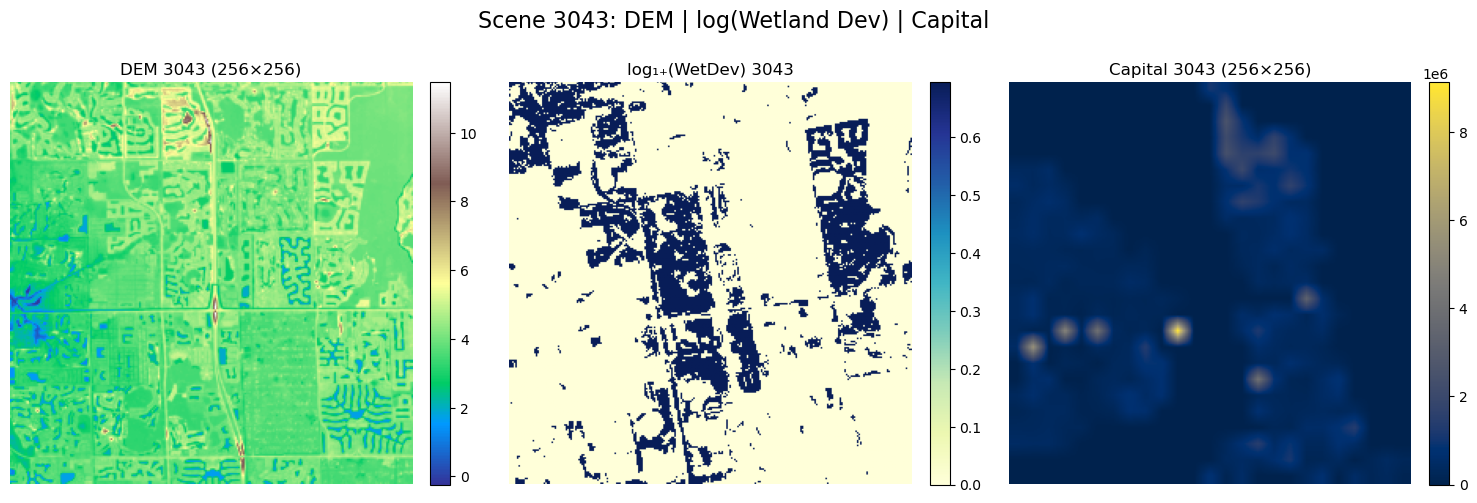

In [3]:
# Sort by log_wetland_dev and take top 10
top10_ids    = top10['scene'].astype(str).tolist()
log_wet_vals = top10['LOG_WETLAND_DEV_1996_2016_HECTARES'].values.astype(float)

# Prepare lists to collect pixel‐level data from all 10 scenes
dem_pixels_list = []
cap_pixels_list = []
wet_pixels_list = []

TARGET_SHAPE = (256, 256)

for scene_id, log_wet in zip(top10_ids, log_wet_vals):
    # Build the actual filenames with prefixes:
    wet_path = folders['wet'] / f"WETLAND_DEV_1996_2016_{scene_id}.tiff"
    dem_path = folders['dem'] / f"DEM_{scene_id}.tiff"
    cap_path = folders['cap'] / f"CAPITAL_1996_{scene_id}.tiff"

    # Read each raster “as is” (no reprojection)
    with rio.open(dem_path) as src_dem:
        dem_arr = src_dem.read(1).astype(np.float32)
    with rio.open(cap_path) as src_cap:
        cap_arr = src_cap.read(1).astype(np.float32)
    with rio.open(wet_path) as src_wet:
        wet_arr = src_wet.read(1).astype(np.float32)

    # Resize to 256×256 using PIL (bilinear)
    dem_resized = np.array(
        Image.fromarray(dem_arr).resize(TARGET_SHAPE, Image.BILINEAR),
        dtype=np.float32
    )
    cap_resized = np.array(
        Image.fromarray(cap_arr).resize(TARGET_SHAPE, Image.BILINEAR),
        dtype=np.float32
    )
    wet_resized = np.array(
        Image.fromarray(wet_arr).resize(TARGET_SHAPE, Image.BILINEAR),
        dtype=np.float32
    )

    # Clip negative wet values to zero, then log1p
    wet_resized_clipped = np.clip(wet_resized, 0, None)
    log_wet_resized = np.log1p(wet_resized_clipped)

    # Flatten into 1D arrays of length 256*256
    dem_pixels = dem_resized.ravel()
    cap_pixels = cap_resized.ravel()
    wet_pixels = log_wet_resized.ravel()

    # Append to lists
    dem_pixels_list.append(dem_pixels)
    cap_pixels_list.append(cap_pixels)
    wet_pixels_list.append(wet_pixels)

# Concatenate from all ten scenes into one big array
dem_all = np.hstack(dem_pixels_list)   # shape (10×256×256,)
cap_all = np.hstack(cap_pixels_list)
wet_all = np.hstack(wet_pixels_list)

# Build design matrix X and response y
X = np.column_stack([dem_all, cap_all])  # shape (N,2) with N=10×65536
y = wet_all                              # shape (N,)

# Fit a single multiple linear regression across all pixels
X_with_const = sm.add_constant(X)   # shape: (N, 3), columns = ['const','DEM','Cap']

# Fit an OLS model:
model = sm.OLS(y, X_with_const)
results = model.fit()

# Convert summary to text or DataFrame:
print(results.summary())

# If you want the coefficients and t-stats in a DataFrame:
df_summary = pd.DataFrame({
    'coef'    : results.params,
    'std_err' : results.bse,
    't_stat'  : results.tvalues,
    'p_value' : results.pvalues,
    'R_squared': [results.rsquared] + [np.nan]*2  # attach R² to the intercept row
}, index=['const', 'DEM', 'Cap'])

print("\nCoefficient summary table:")
print(df_summary)

# For the single “most‐developed” scene (ID=3043), plot the three rasters:
scene_focus = '3043'
wet_f  = folders['wet'] / f"WETLAND_DEV_1996_2016_{scene_focus}.tiff"
dem_f  = folders['dem'] / f"DEM_{scene_focus}.tiff"
cap_f  = folders['cap'] / f"CAPITAL_1996_{scene_focus}.tiff"

# Read and resize:
with rio.open(dem_f) as src:
    dem_3043 = src.read(1).astype(np.float32)
dem_3043 = np.array(Image.fromarray(dem_3043).resize(TARGET_SHAPE, Image.BILINEAR), dtype=np.float32)

with rio.open(cap_f) as src:
    cap_3043 = src.read(1).astype(np.float32)
cap_3043 = np.array(Image.fromarray(cap_3043).resize(TARGET_SHAPE, Image.BILINEAR), dtype=np.float32)

with rio.open(wet_f) as src:
    wet_3043 = src.read(1).astype(np.float32)
wet_3043 = np.array(Image.fromarray(wet_3043).resize(TARGET_SHAPE, Image.BILINEAR), dtype=np.float32)
wet_3043_clipped = np.clip(wet_3043, 0, None)
logwet_3043      = np.log1p(wet_3043_clipped)

# Plot DEM, log‐Wetland, and Capital side by side
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15, 5))

im0 = ax0.imshow(dem_3043, cmap='terrain')
ax0.set_title("DEM 3043 (256×256)")
ax0.axis('off')
plt.colorbar(im0, ax=ax0, fraction=0.046, pad=0.04)

im1 = ax1.imshow(logwet_3043, cmap='YlGnBu')
ax1.set_title("log₁₊(WetDev) 3043")
ax1.axis('off')
plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)

im2 = ax2.imshow(cap_3043, cmap='cividis')
ax2.set_title("Capital 3043 (256×256)")
ax2.axis('off')
plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)

plt.suptitle("Scene 3043: DEM | log(Wetland Dev) | Capital", fontsize=16)
plt.tight_layout(rect=[0,0,1,0.94])
plt.show()


### OUTCOME MODEL

In [4]:
# reading tabular data
cols = ['scene', 'LOG_WETLAND_DEV_1996_2016_HECTARES', 'LOG_CLAIMS_1996_2016', 'LOG_CAPITAL_1996', 'DEM_MEAN']
df = pd.read_csv("/Users/sayedmorteza/Library/CloudStorage/Box-Box/Caltech Research/Scripts/" \
    "WetlandCausalML/tabular_data_florida.csv", usecols=cols)

# finding the top 10 scenes with the most wetland development
top10 = df.sort_values(by='LOG_WETLAND_DEV_1996_2016_HECTARES', ascending=False).head(10).copy()

# Selecting relevant columns for regression
X_tab = top10[['DEM_MEAN', 'LOG_CAPITAL_1996']].values   # shape (10, 2)
y_tab = top10['LOG_CLAIMS_1996_2016'].values             # shape (10,)

# 4. Add a constant (intercept) column to X
X_with_const = sm.add_constant(X_tab)  # shape (10, 3): ['const', 'DEM_MEAN', 'LOG_CAPITAL_1996']

# 5. Fit OLS:  LOG_CLAIMS_1996_2016 ~ DEM_MEAN + LOG_CAPITAL_1996
model = sm.OLS(y_tab, X_with_const)
results = model.fit()

# 6. Print the regression summary (coefficients, t‐stats, R², etc.)
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                 -0.206
Method:                 Least Squares   F-statistic:                    0.2322
Date:                Tue, 03 Jun 2025   Prob (F-statistic):              0.799
Time:                        10:03:50   Log-Likelihood:                -25.924
No. Observations:                  10   AIC:                             57.85
Df Residuals:                       7   BIC:                             58.75
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.5899     37.720      0.281      0.7

/opt/miniconda3/envs/imageTRT/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=10 observations were given.
  return hypotest_fun_in(*args, **kwds)


## Step 3: Making Synthetic Wetland Development Data


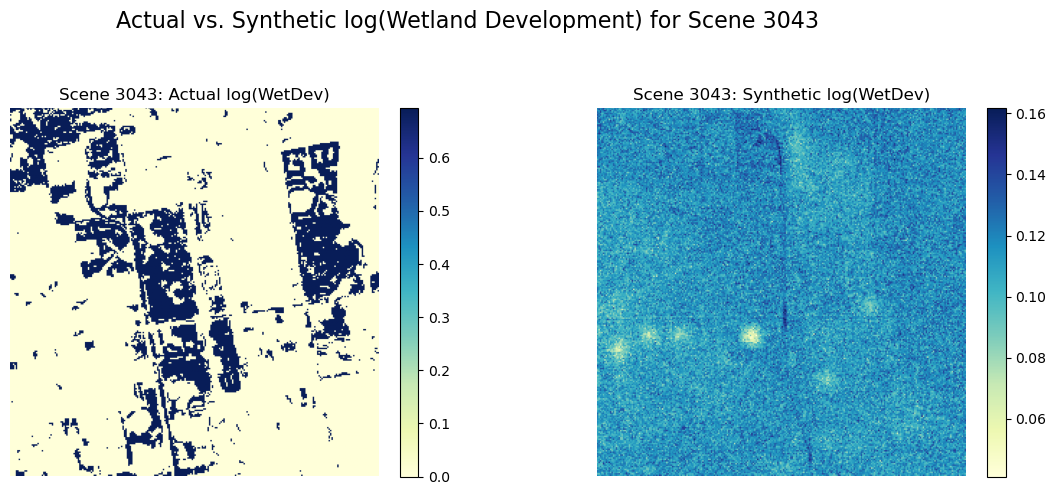

In [5]:
# Fitted values
beta0    = 0.0962
beta_dem = 0.0051
beta_cap = -7.349e-09

# Synthetic wetland development
sigma_noise = 0.01
deterministic = beta0 + beta_dem * dem_3043 + beta_cap * cap_3043
noise = np.random.normal(loc=0.0, scale=sigma_noise, size=dem_3043.shape)
logwet_synth = deterministic + noise
logwet_synth = np.clip(logwet_synth, 0, None)  # Ensure no negative values

# Plot side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

im1 = ax1.imshow(logwet_3043, cmap='YlGnBu')
ax1.set_title("Scene 3043: Actual log(WetDev)")
ax1.axis('off')
fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)

im2 = ax2.imshow(logwet_synth, cmap='YlGnBu')
ax2.set_title("Scene 3043: Synthetic log(WetDev)")
ax2.axis('off')
fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)

plt.suptitle("Actual vs. Synthetic log(Wetland Development) for Scene 3043", fontsize=16)
plt.tight_layout(rect=[0,0,1,0.93])
plt.show()


## Step 4: Making Synthetic Treatment Effect and Potential Outcomes


In [6]:
# Functions for convolution with exponential kernel
def make_exp_kernel(lam_m, cell_size_m, truncate=4):
    """
    Build a normalized 2D exponential‐decay kernel:
      K(d) = exp(−d/lam_m), truncated at 4·lam_m.
    """
    R = int(truncate * lam_m / cell_size_m)
    y, x = np.ogrid[-R:R+1, -R:R+1]
    d    = np.hypot(x, y) * cell_size_m
    K    = np.exp(-d/lam_m)
    K   /= K.sum()
    return K
# Function to convolve a 2D array with an exponential kernel using FFT
def exp_convolve(arr, K):
    """
    Convolve a 2D array `arr` with kernel `K` via FFT, returning same shape.
    """
    return fftconvolve(arr.astype(np.float32), K, mode='same')

# Upstream‐only convolution with exponential kernel
def upstream_only_KuT(T, DEM, K):
    """
    For each pixel x in a 256×256 raster, compute
       KuT_up(x) = sum_{j: DEM[j] > DEM[x]} [ K(d(x,j)) * T[j] ].
    Uses a brute‐force nested loop.  Returns a 256×256 array.
    """

    H, W = T.shape
    R = K.shape[0] // 2  # kernel radius in pixels

    # Pad both T and DEM by R pixels on all sides so we can index neighbors around borders
    T_pad   = np.pad(T,   pad_width=R, mode='constant', constant_values=0.0)
    DEM_pad = np.pad(DEM, pad_width=R, mode='edge')

    KuT_up = np.zeros_like(T, dtype=np.float32)

    # Precompute all (dx, dy) distances and their kernel weights once
    # so we do not have to recompute them for each x.
    # K is shaped (2R+1, 2R+1):
    # K[i,j] corresponds to offset dx = j-R, dy = i-R.
    # We'll use i_row, j_col as kernel indices.
    i_idxs, j_idxs = np.indices(K.shape)
    dy = i_idxs - R
    dx = j_idxs - R
    dist_weights = K  # each entry = exp(-sqrt(dx^2+dy^2)*cell_size / lam) / sum

    # Now loop over every pixel in the 256×256 grid
    for i in range(H):
        for j in range(W):
            # center elevation at (i,j) in the padded array coordinates is DEM_pad[i+R, j+R]
            center_elev = DEM_pad[i + R, j + R]

            # Extract the 2R+1 × 2R+1 neighborhood of DEM_pad and T_pad around (i+R, j+R)
            dem_patch = DEM_pad[i : i + 2*R + 1, j : j + 2*R + 1]
            t_patch   = T_pad[i : i + 2*R + 1, j : j + 2*R + 1]

            # Build a mask of which neighbors are strictly upstream:
            upstream_mask = (dem_patch > center_elev).astype(np.float32)

            # Multiply element‐wise: (K * upstream_mask * t_patch), then sum
            KuT_up[i, j] = np.sum(dist_weights * upstream_mask * t_patch)

    return KuT_up


In [7]:
# Parameters for convolution
CELL_SIZE = 30.0       # metres per pixel (same as before)
LAMBDA    = 5000.0     # characteristic decay length for spillover (m)

# Create the exponential kernel
KERNEL = make_exp_kernel(lam_m=LAMBDA, cell_size_m=CELL_SIZE, truncate=4)

# Compute KuT_up(x) = upstream‐only K_uT(x):
KuT_up_3043 = upstream_only_KuT(logwet_synth, dem_3043, KERNEL)

In [8]:
# Building Heterogeneous Treatment Effect (HTE) model
Bbase  = 0.2       # baseline scaling (tweak to taste)
Beta1  = 1.0      # how strongly log(Capital+1) raises θ
Beta2  = 200.0     # how strongly 1/DEM raises θ

# Ensure we never divide by zero
dem_safe = np.maximum(dem_3043, 1.0)

# Compute the heterogeneous treatment effect θ(x):
theta_3043 = Bbase * (
    1.0 
    + Beta1 * np.log1p(cap_3043)   # log(cap + 1) term
    + Beta2 / dem_safe             # inverse DEM term
)

# Compute convoluted ITE
ITE_3043 = theta_3043 * KuT_up_3043

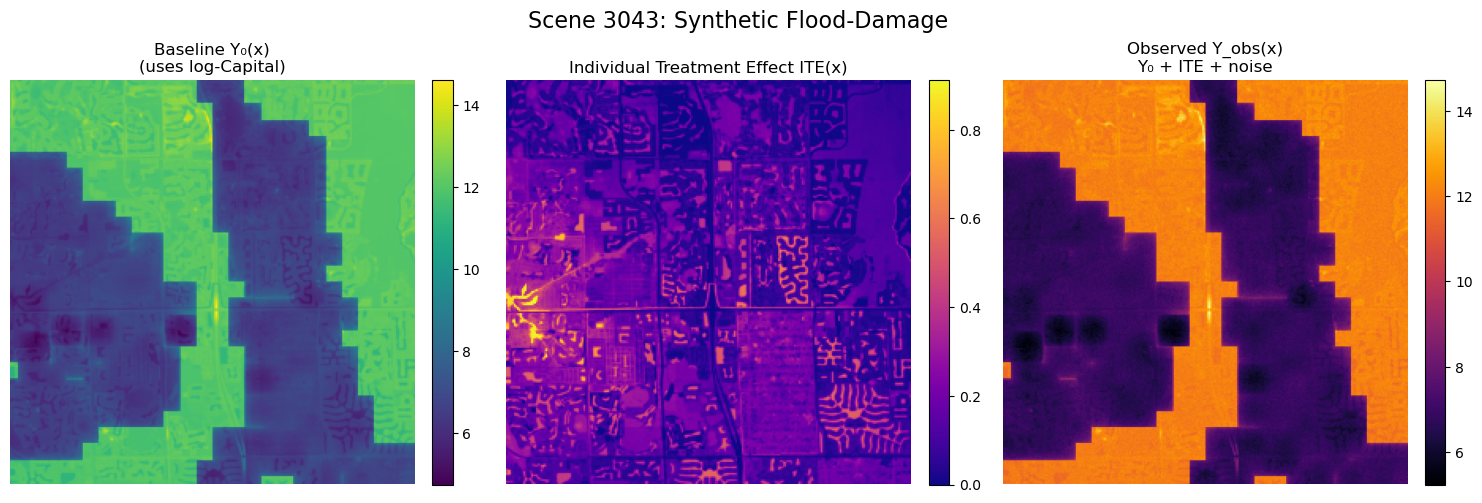

In [11]:
# 1.  Plug in the OLS coefficients from the 10‐scene tabular regression:
alpha0    = 10.5899    # intercept
alpha_dem = 0.3504     # coefficient on DEM_MEAN
alpha_cap = -0.4104    # coefficient on LOG_CAPITAL_1996

# 2.  Build the baseline outcome Y0(x) for each pixel:
#       Y0(i,j) = alpha0 + alpha_dem * dem_resized[i,j] + alpha_cap * cap_resized[i,j]
Y0_3043 = alpha0 + alpha_dem * dem_3043 + alpha_cap * np.log1p(cap_3043)
# Adding ITE
Y1_3043 = Y0_3043 + ITE_3043

sigma_noise = 0.1   # adjust between 0.05–0.2 for more/less scatter
noise = np.random.normal(loc=0.0, scale=sigma_noise, size=dem_3043.shape)

Y_obs_3043 = Y0_3043 + ITE_3043 + noise

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15, 5))

im0 = ax0.imshow(Y0_3043, cmap='viridis')
ax0.set_title("Baseline Y₀(x)\n(uses log-Capital)")
ax0.axis('off')
plt.colorbar(im0, ax=ax0, fraction=0.046, pad=0.04)

im1 = ax1.imshow(ITE_3043, cmap='plasma')
ax1.set_title("Individual Treatment Effect ITE(x)")
ax1.axis('off')
plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)

im2 = ax2.imshow(Y_obs_3043, cmap='inferno')
ax2.set_title("Observed Y_obs(x)\nY₀ + ITE + noise")
ax2.axis('off')
plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)

plt.suptitle("Scene 3043: Synthetic Flood‐Damage", fontsize=16)
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()

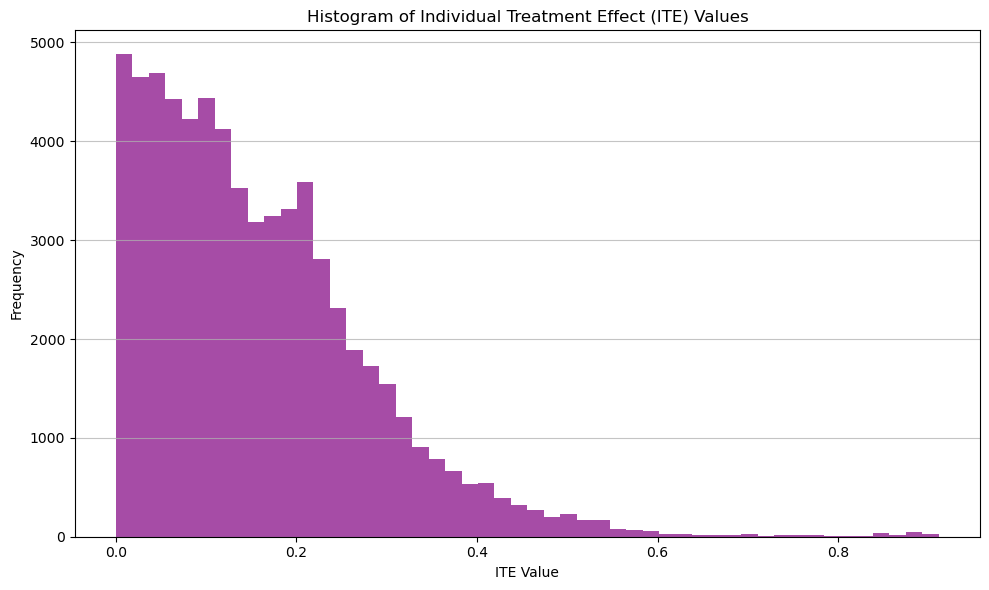

In [16]:
# Histogram of ITE values
plt.figure(figsize=(10, 6))
plt.title("Histogram of Individual Treatment Effect (ITE) Values")
plt.hist(ITE_3043.ravel(), bins=50, color='purple', alpha=0.7)
plt.xlabel("ITE Value")
plt.ylabel("Frequency")
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()

In [17]:
import pickle
with open('ITE_3043.pkl', 'wb') as f:
    pickle.dump(ITE_3043, f)
with open('theta_3043.pkl', 'wb') as f:
    pickle.dump(theta_3043, f)
with open('KuT_up_3043.pkl', 'wb') as f:
    pickle.dump(KuT_up_3043, f)
with open('KERNEL.pkl', 'wb') as f:
    pickle.dump(KERNEL, f)
with open('dem_3043.pkl', 'wb') as f:
    pickle.dump(dem_3043, f)
with open('cap_3043.pkl', 'wb') as f:
    pickle.dump(cap_3043, f)
with open('logwet_synth.pkl', 'wb') as f:
    pickle.dump(logwet_synth, f)
with open('logwet_3043.pkl', 'wb') as f:
        pickle.dump(logwet_3043, f)
with open('Y_obs_3043.pkl', 'wb') as f:
    pickle.dump(Y_obs_3043, f)

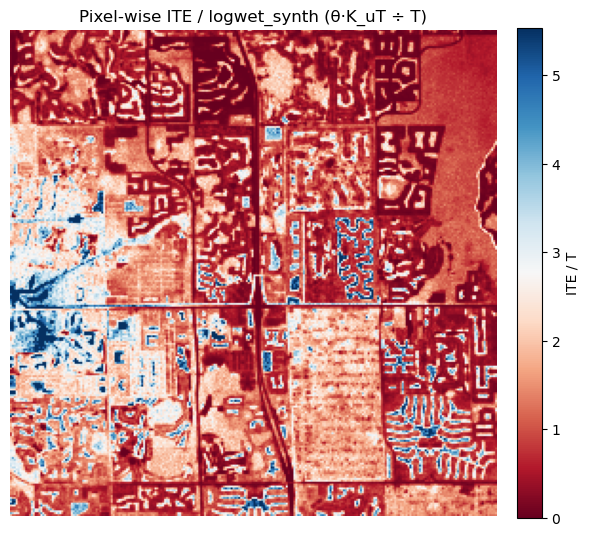

In [ ]:
# Compute the ratio elementwise
ratio = ITE_3043 / logwet_synth    # whenever T==0, ratio will be NaN

# Step 4. Plot the ratio as an image
plt.figure(figsize=(6, 6))
im = plt.imshow(ratio, cmap='RdBu', vmin=0, vmax=np.nanpercentile(ratio, 99))
plt.title("Pixel‐wise ITE / logwet_synth (θ·K_uT ÷ T)")
plt.axis('off')
cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
cbar.set_label("ITE / T")
plt.tight_layout()
plt.show()

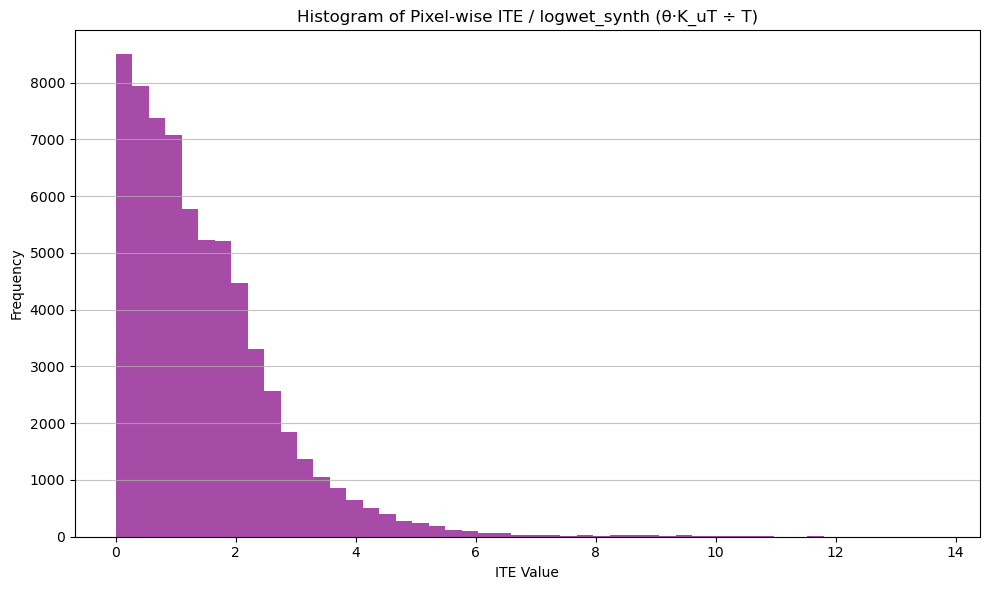

In [19]:
# Histogram of ITE values
plt.figure(figsize=(10, 6))
plt.title("Histogram of Pixel‐wise ITE / logwet_synth (θ·K_uT ÷ T)")
plt.hist(ratio.ravel(), bins=50, color='purple', alpha=0.7)
plt.xlabel("ITE Value")
plt.ylabel("Frequency")
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()